# Fraud Detection Using Anamoly Based Methods and Weighted Logistic Regression

Notebook delves into Isolation Forest, LOF, and weighted Log Reg

Dataset found on Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
random_state = 0
df = pd.read_csv('creditcard.csv')

In [3]:
# no NA's
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [4]:
df[df.duplicated()]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,...,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,...,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
# shuffle df and sample
# divvy into non_fraud and fraud
# very imbalanced dataset
#df = df.sample(frac=0.2, random_state=random_state)
mask = df['Class'] == 0
non_fraud = df[mask]
fraud = df[~mask]
contamination = len(fraud)/float(len(non_fraud))
print('Conatmination: {}'.format(contamination))
print('Non-Fraud: {}'.format(non_fraud.shape[0]))
print('Fraud: {}'.format(fraud.shape[0]))

Conatmination: 0.0016698852262818046
Non-Fraud: 283253
Fraud: 473


In [7]:
non_fraud.Amount.describe()

count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64

In [8]:
fraud.Amount.describe()

count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

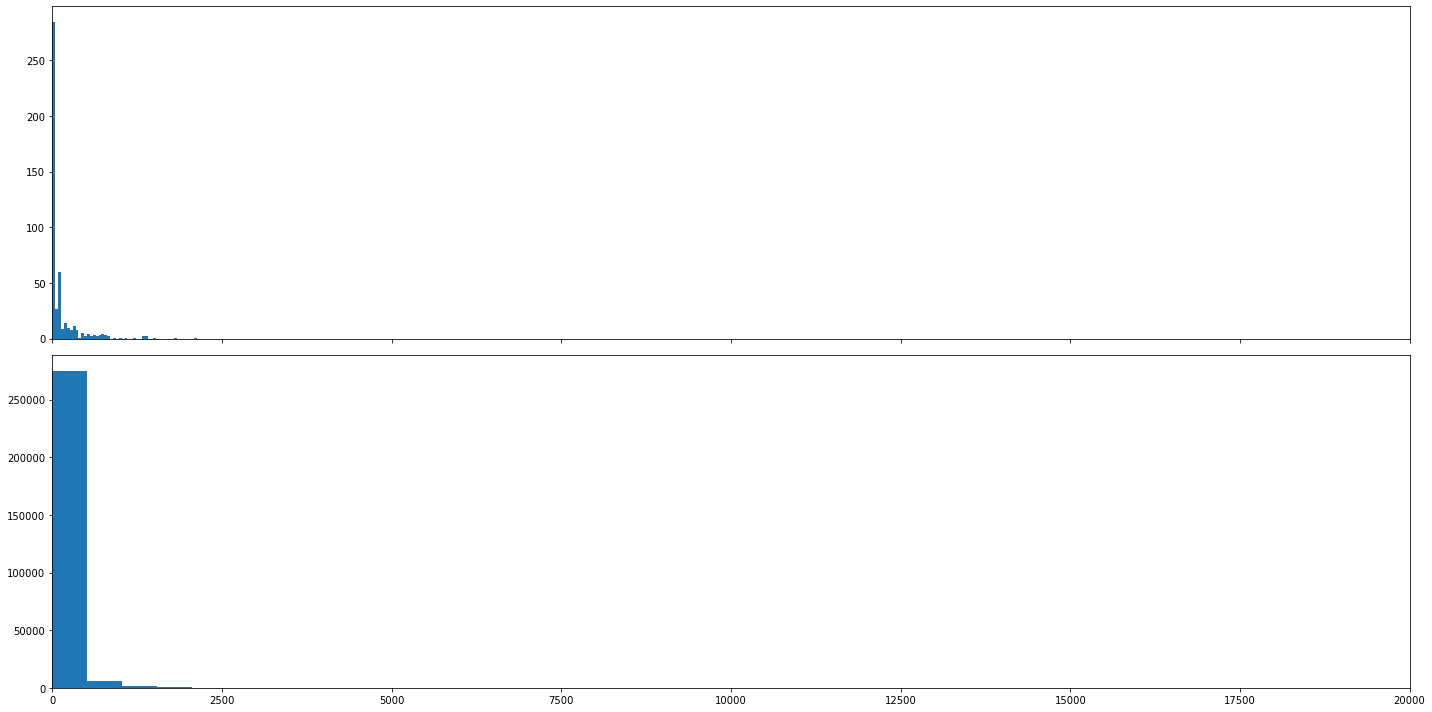

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20,10))
ax[0].hist(fraud.Amount, bins=50)
ax[1].hist(non_fraud.Amount, bins=50)
plt.xlim((0, 20000))
plt.tight_layout()

In [10]:
def high_corr(corr):
    high_corrs = []
    for col in corr.columns:
        index = corr[col].index
        for pos in range(len(index)):
            if np.abs(corr[col][pos]) >= 0.75 and index[pos] != col:
                high_corrs.append([col, index[pos], corr[col][pos]])
    
    # remove duplicates by score
    high_corrs= list(dict((x[2], x) for x in high_corrs).values())
    return high_corrs

high_corrs = high_corr(df.corr())
high_corrs

[]

## Isolation Forest
Unsupervised technique for anomaly detection. You can think of it as an extension of ExtraTrees*, where each 'isolation tree' splits on a randomly chosen feature between the feature's minimum and maximum value. The logic behind doing so is that anomalies will be easily split, as only very few conditions need to be met to isolate the outliers, whereas normal observations will require more splits. Generally, the shorter the path between the split node and the root node, the more anamalous the data point is. An isolation forest combines many 'isolation trees' and aggregates the output (i.e. averages the path length)

*
The implementation is based on an ensemble of ExtraTreeRegressor. The maximum depth of each tree is set to ceil(log_2(n)) where n is the number of samples used to build the tree 

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score

In [12]:
# final_df = pd.concat([fraud, non_fraud])
# final_df.shape

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=random_state)
X_train = train.loc[:, train.columns != 'Class']
y_train = train.Class

X_test = test.loc[:, test.columns != 'Class']
y_test = test.Class

In [14]:
isof = IsolationForest(n_estimators=100, max_features = int(np.sqrt(X_train.shape[1])), contamination=contamination, random_state=random_state)
isof.fit(X_train)
y_pred = isof.predict(X_test)
# -1 is fraud
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != y_test).sum()
print(n_errors)
print(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

147
0.6185222585183952
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56659
           1       0.22      0.26      0.24        87

    accuracy                           1.00     56746
   macro avg       0.61      0.63      0.62     56746
weighted avg       1.00      1.00      1.00     56746



## Local Outlier Factor LOF

Unsupervised anomaly detection method by considering local densities of data points. It considers outliers to be points that have significantly lower density than its neighbors.

More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers

In [15]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=True)
lof.fit(X_train)
y_pred_lof = lof.predict(X_test)
y_pred_lof[y_pred_lof == 1] = 0
y_pred_lof[y_pred_lof == -1] = 1

In [16]:
print(f1_score(y_test, y_pred_lof, average='macro'))
print(classification_report(y_test, y_pred_lof))

0.5322168785234711
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56659
           1       0.06      0.07      0.07        87

    accuracy                           1.00     56746
   macro avg       0.53      0.53      0.53     56746
weighted avg       1.00      1.00      1.00     56746



## Logistic Regression
For imbalanced data, we can choose to incorporate oversampling/undersampling techniques, or shift class weights in logistic regression. Latter works better in this case.

By default, the errors for each class may be considered to have the same weighting, say 1.0. These weightings can be adjusted based on the importance of each class. minimize sum i to n -(w0 * log(yhat_i) * y_i + w1 * log(1 – yhat_i) * (1 – y_i)) 

The weighting is applied to the loss so that smaller weight values result in a smaller error value, and in turn, less update to the model coefficients. A larger weight value results in a larger error calculation, and in turn, more update to the model coefficients.

- Small Weight: Less importance, less update to the model coefficients.
- Large Weight: More importance, more update to the model coefficients.

In [17]:
# undersample on train and evaluate on test
# in industry will be hard to label data
pd.Series(y_train).value_counts()

0    226594
1       386
Name: Class, dtype: int64

In [18]:
mask = train['Class'] == 0
non_fraud_train = train[mask]
fraud_train = train[~mask]
non_fraud_train = non_fraud_train.sample(frac=1)
non_fraud_train = non_fraud_train[:330]
lr_train = pd.concat([non_fraud_train, fraud_train])

In [19]:
X_train_lr = train.loc[:, train.columns != 'Class']
y_train_lr = train.Class

In [20]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(LogisticRegression(random_state=random_state, max_iter=10000, 
                                       class_weight={0: 0.2, 1:0.8}), cv=5, param_grid=param_grid, scoring='f1_macro')
grid.fit(X_train_lr, y_train_lr)
print(grid.best_params_)
y_pred_lr = grid.predict(X_test)

{'C': 0.01}


In [21]:
print(f1_score(y_test, y_pred_lr, average='macro'))
print(classification_report(y_test, y_pred_lr))

0.8115190589608994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56659
           1       0.59      0.67      0.62        87

    accuracy                           1.00     56746
   macro avg       0.79      0.83      0.81     56746
weighted avg       1.00      1.00      1.00     56746



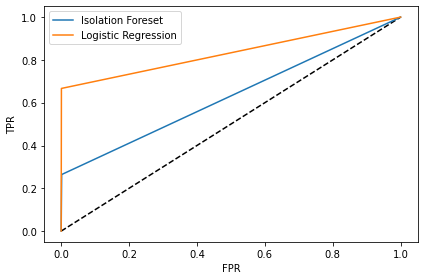

In [23]:
fpr_if, tpr_if, thresholds = roc_curve(y_test, y_pred, pos_label=1)
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred_lr, pos_label=1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_if, tpr_if, label='Isolation Foreset')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.tight_layout()

## References: 
- https://www.youtube.com/watch?v=CePgbdVdLvg
- https://machinelearningmastery.com/cost-sensitive-logistic-regression/
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html